<a href="https://colab.research.google.com/github/mirwisek/emotion-classification-twitter/blob/main/03_BERTweet_Movies_Review_Sentiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://i.imgur.com/KOjXRJg.jpg)

### <b><span style='color:#F1A424'>Test Classification</span></b>

- Text classification is one of the most common tasks in NLP
- It can be used for a wide range of applications (eg. tagging customer feedback into categories, routing support tickets according to their language)
- Another common type of text classification problem is **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">sentiment analysis</mark>** which aims to **identify the polatity** of a given text (+/-)

### <b><span style='color:#F1A424'>Our Task</span></b>

- We need to build a system that will be able to automatically identify emotional states (eg. anger, joy) that people express about your company's product on twitter
- For this task, we'll be using a variant of **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">BERT</mark>**; **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">DistilBERT</mark>**, the main advantage of this model is that it is much smaller than **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">BERT</mark>** (ie. more efficient), but is able to achieve comparable performance
- We will be using three core libraries from the **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">Hugging Face</mark>** ecosystem: **<span style='color:#FFC300'>Datasets</span>**, **<span style='color:#FFC300'>Tokenizers</span>** & **<span style='color:#FFC300'>Transformers</span>**

In [1]:
!pip install -q datasets --upgrade
!pip install -q transformers[torch] -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 26.4 MB/s eta 0:00:00


# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-color:#3b3745"><b><span style='color:#F1A424'>1 |</span></b> <b>THE DATASET</b></div>
    
- Many data sets involving **sentiment** analysis are **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">binary</mark>** classification problems
- In this dataset we have **6 different sentiments**, which means we'll be treating this problem as a **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">multiclass</mark>** classification problem

In [2]:
!mkdir data
!wget -q https://github.com/mirwisek/emotion-classification-twitter/raw/main/data/training.csv -O ./data/training.csv
!wget -q https://github.com/mirwisek/emotion-classification-twitter/raw/main/data/test.csv -O ./data/test.csv
!wget -q https://github.com/mirwisek/emotion-classification-twitter/raw/main/data/validation.csv -O ./data/validation.csv

In [3]:
!wget -q https://github.com/mirwisek/emotion-classification-twitter/raw/main/data/IMDB_Dataset_train.csv -O ./data/IMDB_Dataset_train.csv

In [4]:
!ls data

IMDB_Dataset_train.csv	test.csv  training.csv	validation.csv


In [215]:
import pandas as pd
import numpy as np
import panel as pn
import warnings; warnings.filterwarnings('ignore')

def show_panel(df):
    return pn.widgets.Tabulator(df.head(20),
                    show_index=False,
                    pagination='local',
                         page_size=10)


pn.extension('tabulator')
pn.widgets.Tabulator.theme = 'bootstrap'

movies = pd.read_csv('./data/IMDB_Dataset_train.csv')

movies_train = movies[:40000]
movies_validation = movies[40000:45000]
movies_test = movies[45000:]

movies_train.rename(columns={'sentiment': 'label'}, inplace=True)
movies_test.rename(columns={'sentiment': 'label'}, inplace=True)
movies_validation.rename(columns={'sentiment': 'label'}, inplace=True)


print('Dataset information:')
print(f'Movies train data: {movies_train.shape}')
print(f'Movies validation data: {movies_validation.shape}')
print(f'Movies test data: {movies_test.shape}')
show_panel(movies)

Dataset information:
Movies train data: (40000, 2)
Movies validation data: (5000, 2)
Movies test data: (5000, 2)


Tabulator(page_size=10, pagination='local', show_index=False, value=                          ...)

In [216]:
show_panel(movies_train)

Tabulator(page_size=10, pagination='local', show_index=False, value=                          ...)

### <b><span style='color:#F1A424'>Combine DataFrames into Dataset</span></b>
- It can be more intuitive to utilise **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">HuggingFace</mark>**'s Dataset  

In [219]:
from datasets import Dataset,DatasetDict,Features,Value,ClassLabel

# Don't forget the class label data
class_names = ['positive', 'negative']
ft = Features({'review': Value('string'), 'label': ClassLabel(names=class_names)})

# Combine Multiple Datasets
movies = DatasetDict({
    "train": Dataset.from_pandas(movies_train,features=ft),
    "test": Dataset.from_pandas(movies_test,features=ft),
    "validation": Dataset.from_pandas(movies_validation,features=ft)
})

# Convert a single DataFrame to a Dataset
# emotions = Dataset.from_pandas(train,features=ft)

movies

DatasetDict({
    train: Dataset({
        features: ['review', 'label'],
        num_rows: 40000
    })
    test: Dataset({
        features: ['review', 'label'],
        num_rows: 5000
    })
    validation: Dataset({
        features: ['review', 'label'],
        num_rows: 5000
    })
})

### <b><span style='color:#F1A424'>Selecting a Subset</span></b>
- We'll be working with the **training and validation dataset** in this problem
- Lets just show some useful fearures of the **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">Dataset</mark>** class

In [220]:
# Training Data
train_ds = movies["train"]
train_ds

Dataset({
    features: ['review', 'label'],
    num_rows: 40000
})

In [221]:
# Get First 5 Entries in Dictionary Format (Group them)
train_ds[:5]

{'review': ["One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is d

### <b><span style='color:#F1A424'>Dataset to DataFrame Convertion</span></b>
- Whenever we need a pandas `DataFrame`, eg. for visualisations, we can utlise the `Dataset`'' method `.set_format`

In [222]:
# Convert Dataset to DataFrame (don't forget to reset)
movies.set_format(type="pandas")
df = movies["train"][:]
show_panel(df)

Tabulator(page_size=10, pagination='local', show_index=False, value=                          ...)

### <b><span style='color:#F1A424'>Adding Label Data</span></b>
- We made sure to not forget the `label_names` when converting from `DataFrame` to `Dataset`
- We can convert **numeric** values to **string** values by using method `int2str`

In [223]:
# Add label data to dataframe
def label_int2str(row):
    return movies["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
show_panel(df)

Tabulator(page_size=10, pagination='local', show_index=False, value=                          ...)

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-color:#3b3745"><b><span style='color:#F1A424'>2 |</span></b> <b>CLASS DISTRIBUTION</b></div>

- Our dataset has 6 classes `joy`, `sadness`, `anger`, `fear`, `love` and `surprise`; multiclass problem

In [224]:
import plotly.express as px

px.bar(df['label_name'].value_counts(ascending=True),template='plotly_white')

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-color:#3b3745"><b><span style='color:#F1A424'>3 |</span></b> <b>LENGTH OF EACH TWEET</b></div>

- For applications using **DistilBERT**, the maximum context size is **512 tokens**
- Most tweets are around **10-20 words** long, which falls well within this limit

In [225]:
df["Words Per Review"] = df["review"].str.split().apply(len)

px.box(df,y='Words Per Review',
       color='label_name',
       template='plotly_white')

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-color:#3b3745"><b><span style='color:#F1A424'>4 |</span></b> <b>TOKENISATION</b></div>

- As with other models, **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">DistilBERT</mark>** cannot receive raw python strings as input
- Instead we need to break down the strings into subgroups called **tokens** and encode them as **numerical vectors**
- Let's consider two types of **tokenisation** approaches: **<span style='color:#FFC300'>character</span>** & **<span style='color:#FFC300'>word</span>** tokenisation

### <b><span style='color:#F1A424'> 4.2 | </span>Word tokenisation </b>

- Instead of splitting the text into characters, we can split **it into words** & **map each word to an integer**
- The simplest form of tokenisation is if we utilise python's inbuilt **string** class `split` method
- Unlike **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">Character tokenisation</mark>**, if we have declinations, conjugations, misspellings, the size of the **vocabulary dictionary** can grow very rapidly
- Larger **vocabularies** are a problem, because it requires the model to have an excess of parameters (which is inefficient)


- It's common to select the **<span style='color:#FFC300'>most common 100,000 words</span>** in the **corpus**
- words that are not part of the vocabulary are classified as unknown and mapped to a shared **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">UNK</mark>** token
- However, can potentially lose some important information during the process of tokenisation, since the model has no information about words associated with **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">UNK</mark>**

In [226]:
text = 'Tokenisation of text is a core task of NLP.'
tokenised_text = text.split()
print(tokenised_text)

['Tokenisation', 'of', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


### <b><span style='color:#F1A424'> 4.3 | </span>Subword tokenisation </b>

- **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">Subword tokenization</mark>** is to combine the best aspects of **<span style='color:#FFC300'>character</span>** & **<span style='color:#FFC300'>word</span>** tokenisation
- The main distinguishing feature of **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">Subword tokenization</mark>** is that it is learned from a **pretraining corpus** using a mix of statistical rules and algorithms


- There are several **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">Subword tokenization</mark>** algorithms that are commonly used in NLP
    - let’s start with `WordPiece`, which is used by the `BERT` and `DistilBERT` tokenizers
    

- `AutoTokenizer` class allows us to quickly load te tokeniser associated with a pretrained model
- Or we can load the Tokeniser manually from `transformers.DistilBertTokenizer`



In [227]:
from transformers import AutoTokenizer

text = 'Tokenisation of text is a core task of NLP.'

# Load parameters of the tokeniser
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False)

# Show tokeniser information
tokenizer

BertweetTokenizer(name_or_path='vinai/bertweet-base', vocab_size=64000, model_max_length=128, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	64000: AddedToken("<mask>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [228]:
print('')
print(f'Vocab size: {tokenizer.vocab_size}')
print(f'Max length: {tokenizer.model_max_length}')
print(f'Tokeniser model input names: {tokenizer.model_input_names}')


Vocab size: 64000
Max length: 128
Tokeniser model input names: ['input_ids', 'token_type_ids', 'attention_mask']


In [229]:
print('Encoded text')
encoded_text = tokenizer(text)
print(encoded_text,'\n')

print('Tokens')
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens,'\n')

print('Convert tokens to string')
print(tokenizer.convert_tokens_to_string(tokens),'\n')

Encoded text
{'input_ids': [0, 1261, 6186, 15516, 15, 635, 17, 11, 5269, 6840, 15, 33489, 24223, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]} 

Tokens
['<s>', 'To@@', 'ken@@', 'isation', 'of', 'text', 'is', 'a', 'core', 'task', 'of', 'NL@@', 'P.', '</s>'] 

Convert tokens to string
<s> Tokenisation of text is a core task of NLP. </s> 



### <b><span style='color:#F1A424'> 4.4 | </span>Tokenising the entire dataset </b>

- When dealing with **text of different size**, the tokeniser will **<span style='color:#FFC300'>pad</span>** sentences of insufficient length if **padding** is selected
- The **maximum length** of the tokenised data will be the **length of the longest tweet** (in example, 2nd row)
- **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">Attention mask</mark>** helps the model understand which parts of the sentence to ignore

In [230]:
movies.reset_format()

In [231]:
# Tokenisation function
def tokenise(batch, colname='review'):
    return tokenizer(batch[colname], padding=True, truncation=True)

In [232]:
movies["train"][:2]

{'review': ["One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is d

In [233]:
# Show the tokenised ids
ex_tokenised = tokenise(movies["train"][:2])

In [234]:
# Show attention mask
ex_tokenised['attention_mask']

[[1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,

In [235]:
# apply to the entire dataset (train,test and validation dataset)
movies_encoded = movies.map(tokenise, batched=True, batch_size=None)
print(movies_encoded["train"].column_names)

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

['review', 'label', 'input_ids', 'token_type_ids', 'attention_mask']


# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-color:#3b3745"><b><span style='color:#F1A424'>5 |</span></b> <b>TRAINING A TEXT CLASSIFIER</b></div>

- **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">DistilBERT</mark>** are pretrained to **predict masked words in a sentence of text**
- We **can't use these language models directly** for text classification, need some slight modification


- First the text is tokenised, represented using one-hot vectors called **token encodings**
- The size of the tokeniser vocabulary determines the dimension of the next encoding (usually 20-200k)
- Next these token encodings are converted to token embeddings (vectors living in a lower dimensional space)
- The token embeddings are then passed through the encoder block layers to yield a hidden state for each input token
- For the pretrained objective of language modeling, each hidden state is fed to a layer that predicts the masked input tokens
- For the the **<span style='color:#FFC300'>classification task</span>**, we replace the **<span style='color:#FFC300'>language modeling layer</span>** with a **<span style='color:#FFC300'>classification layer</span>**

We have **<span style='color:#FFC300'>two options</span>** to train such a model on our dataset:
- **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">Feature Extraction</mark>** : We use the hidden states as features, and just train the classifier on them, without modifying the pretrained model
- **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">Fine Tuning</mark>** : We train the whole model, end-to-end, which subsequently also updates the parameters of the pretrained model


### <b><span style='color:#F1A424'> 5.1 | </span>Transformers as feature extractors </b>

### **<span style='color:#F1A424'>Using Pretrained Models</span>**

- We will use another auto class `AutoModel`, similar to `AutoTokenizer`
- `AutoModel` has method `from_pretrained` method to load weights of a pretrained model
- `AutoModel` class converts the token encodings to embeddings & feeds them through the encoder stack to return the **hidden states**

In [363]:
import warnings; warnings.filterwarnings('ignore')
from transformers import AutoModel
import torch

model_ckpt = "vinai/bertweet-base"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

### **<span style='color:#F1A424'>Extracting the last hidden state (example)</span>**
Let's extract the last **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">hidden state</mark>** for a single string
- First things first, let's encode the string and convert the tokens to Pytorch tensors
- Resulting tensor has shape **[batch_size,n_tokens]**
- Having encodings as tensors, the final step is to place them on the same device as the model & pass the inputs as follows

In [187]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


- Depending on the model configuration, the model can contain several objects (**<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">Hidden states</mark>**, **losses**, **attentions**, ...)
- The current model (`distilbert-base-uncased`) returns only one attribute, which is the `last_hidden_state`

In [188]:
inputs.items()

dict_items([('input_ids', tensor([[   0,   33,   17,   11, 1156,    2]])), ('token_type_ids', tensor([[0, 0, 0, 0, 0, 0]])), ('attention_mask', tensor([[1, 1, 1, 1, 1, 1]]))])

In [189]:
inputs = {k:v.to(device) for k,v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.2405,  0.3081,  0.1882,  ...,  0.1010, -0.4676,  0.0276],
         [ 0.0298,  0.2988,  0.2825,  ...,  0.2713, -0.4568, -0.3133],
         [-0.2241, -0.0755,  0.1932,  ...,  0.1158, -0.2709,  0.1020],
         [ 0.0924,  0.3581,  0.0325,  ...,  0.0245, -0.1786,  0.0019],
         [-0.1289, -0.2198, -0.0586,  ..., -0.1178,  0.1179,  0.0225],
         [-0.6375, -0.0990,  0.1849,  ..., -0.1111,  0.0445, -0.2033]]],
       device='cuda:0'), pooler_output=tensor([[ 2.1911e-01, -2.1053e-01,  8.4455e-02, -9.1353e-02,  6.4617e-02,
         -1.3409e-01,  3.0216e-02, -6.4690e-03,  3.8449e-01, -1.2321e-01,
         -8.1946e-03, -1.4893e-02, -2.2165e-01,  1.0643e-01,  7.2627e-02,
         -2.7479e-02, -1.6444e-01,  1.1126e-01,  1.0553e-02, -7.4239e-02,
         -4.5245e-02, -2.3168e-01,  3.6088e-01,  1.6600e-02, -3.8506e-02,
         -4.2904e-02, -1.8707e-01, -1.9952e-01,  1.9387e-01, -1.7768e-01,
         -1.3767e-02, -6.1

- The hidden state tensor (`last_hidden_state`) has the size: **[batch_size,n_tokens,hidden_dim]**
- ie. 768 dimensional vector is returned for each of the 6 input tokens


- For **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">classification tasks</mark>**
    - it is common practice to just use the **hidden state associated with the [CLS] token** as the input feature

In [190]:
print(outputs.last_hidden_state.size())
print(outputs.last_hidden_state[:,0].size())

torch.Size([1, 6, 768])
torch.Size([1, 768])


### **<span style='color:#F1A424'>Extracting the last hidden state for the Dataset</span>**

- We know how to get the last hidden state for a single string, let's repeat the process for the entire dataset using `extract_hidden_states`

In [ ]:
def extract_hidden_states(batch):

    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state

    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [ ]:
movies_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
movies_encoded

In [ ]:
# Extract last hidden states (faster w/ GPU)
movies_hidden = movies_encoded.map(extract_hidden_states, batched=True)
movies_hidden["train"].column_names

### **<span style='color:#F1A424'>Creating the Feature Matrix</span>**

- We have **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">hidden states</mark>** assciated with each tweet, now let's train the classifier
- To do that we need the feature matrix so we can utilise as input into the machine learning model

In [237]:
X_train = np.array(movies_hidden["train"]["hidden_state"])
X_valid = np.array(movies_hidden["validation"]["hidden_state"])
y_train = np.array(movies_hidden["train"]["sentiment"])
y_valid = np.array(movies_hidden["validation"]["sentiment"])
print(f'Training Dataset: {X_train.shape}')
print(f'Validation Dataset {X_valid.shape}')

Training Dataset: (40000, 768)
Validation Dataset (5000, 768)


In [238]:
# Let's check our dataset
X_train

array([[-0.18889792,  0.2082722 ,  0.14894952, ..., -0.12618159,
        -0.24569385, -0.23730536],
       [ 0.07493218,  0.05908709,  0.20131688, ..., -0.12010632,
        -0.04628819, -0.07951593],
       [-0.01441029,  0.28826708,  0.12409551, ..., -0.02448436,
        -0.07217386, -0.21877769],
       ...,
       [ 0.14626615,  0.05458061,  0.15177551, ..., -0.27521005,
        -0.05405836, -0.12838528],
       [ 0.10504236,  0.22387241,  0.14795776, ..., -0.03684983,
        -0.4088852 , -0.19191167],
       [-0.13285655,  0.26127306,  0.25831267, ..., -0.10441644,
        -0.09008493, -0.19092515]], dtype=float32)

### **<span style='color:#F1A424'>Visualising the Training Data</span>**

- We can visualise each class distribution the model will need to separate in **<span style='color:#FFC300'>lower dimension space</span>** (projections onto a lower-dimensional space)
- We have a lot of **categories overlapping** in lower dimensional space (doesn't mean the model won't be able to classify them in **<span style='color:#FFC300'>higher dimensional space</span>**)
- If they are separable in the projected space, they will probably be separable in **<span style='color:#FFC300'>higher dimensional space</span>**
- We'll utilise a **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">manifold learning</mark>** unsupervised model **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">TSNE</mark>** (It will take a while)

In [197]:
import warnings; warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

# Scale the data
X_scaled = MinMaxScaler().fit_transform(X_train)

# lower dimension transformation
model = TSNE(n_components=2).fit(X_scaled)

# Create a df of 2D embeddings
df_embedding = pd.DataFrame(model.embedding_, columns=["X", "Y"])
df_embedding["sentiment"] = y_train

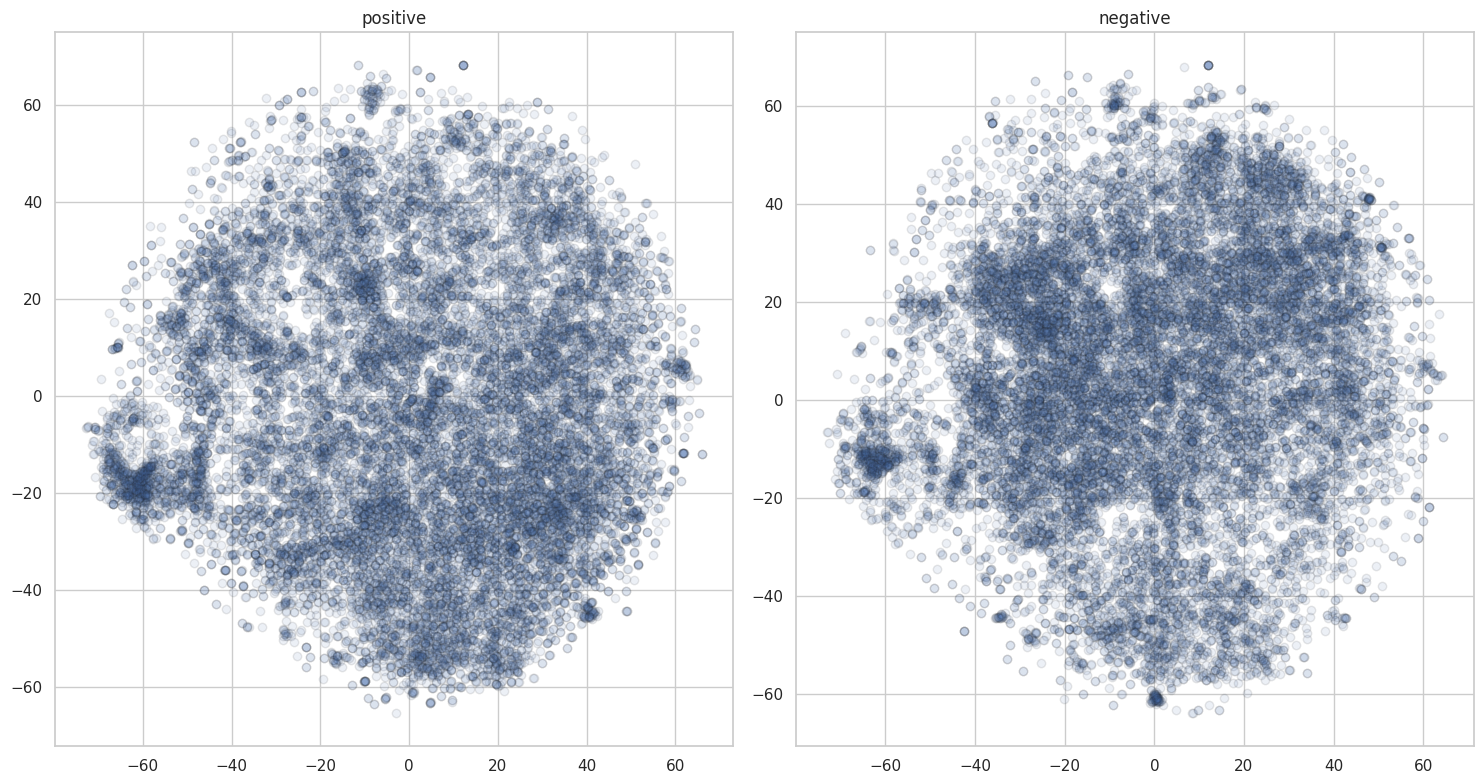

In [206]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')

fig, axes = plt.subplots(1, 2, figsize=(15,8))
axes = axes.flatten()
labels = movies["train"].features["sentiment"].names

for i, label in enumerate(labels):

    dict_embedding_sub = dict(tuple(df_embedding.groupby('sentiment')))
    df_embedding_sub = dict_embedding_sub[i]

    axes[i].scatter(df_embedding_sub["X"],
                    df_embedding_sub["Y"],
                    lw=1,ec='k',alpha=0.1)

    axes[i].set_title(f'{label}')

plt.tight_layout()
plt.show()

From this plot we can see some clear patterns:
- For **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">positive emotions</mark>** (**<span style='color:#FFC300'>joy</span>** and **<span style='color:#FFC300'>love</span>**) are well separated from the **<span style='color:#FFC300'>negative emotions</span>** and also share a similar space
- **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">Negative emotions</mark>** (**<span style='color:#FFC300'>sadness</span>**, **<span style='color:#FFC300'>anger</span>**, and **<span style='color:#FFC300'>fear</span>**) all occupy very similar regions with slightly varying distributions in **<span style='color:#FFC300'>lower dimension space</span>**
- Finally, **<span style='color:#FFC300'>surprise</span>** is somewhat scattered all over the **<span style='color:#FFC300'>lower dimension space</span>**

### **<span style='color:#F1A424'>Training a Baseline Model</span>**

- Let's use these **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">hidden states</mark>** to train a **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">logistic regression</mark>** model
- We're dealing with an unbalanced multiclass dataset, so our model may seem just better than random, but its actually better, let's compare to a `DummyClassifier`
- `DummyClassifier` can be used to build a classifier with simple heuristics (choosing the majority class/always drawing a random class),
- Let's choose most frequent (`strategy="most_frequent"`) so we have a reference model for comparison

In [239]:
from sklearn.linear_model import LogisticRegression as LR

# We increase `max_iter` to guarantee convergence
lr_clf = LR(max_iter = 2000)
lr_clf.fit(X_train, y_train)
y_preds = lr_clf.predict(X_valid)
print(f'accuracy: {lr_clf.score(X_valid, y_valid)}')

accuracy: 0.8488


### <b><span style='color:#F1A424'>Confusion Matrix</span></b>

- Our **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">logistic regression</mark>** model with `DistilBERT` **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">embeddings</mark>** is signifcantly better than the baseline `DummyClassifier`
- Let check the **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">confusion matrix</mark>** of the **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">logistic regression</mark>** model

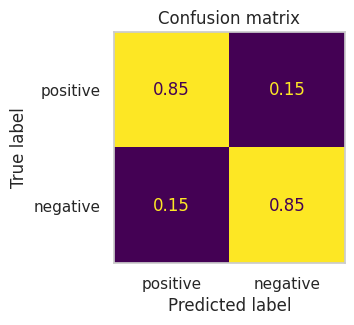

In [209]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_model, y_true, labels):
    cm = confusion_matrix(y_true,y_model,normalize='true')
    fig, ax = plt.subplots(figsize=(3,3))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels, )
    disp.plot(ax=ax, colorbar=False)
    plt.title("Confusion matrix")
#     plt.axis('off')
    plt.grid(False)
    plt.show()

plot_confusion_matrix(y_preds, y_valid, labels)

From the **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">confusion matrix</mark>** we can say that:

- **<span style='color:#FFC300'>anger</span>**, **<span style='color:#FFC300'>fear</span>** & **<span style='color:#FFC300'>surprise</span>** often confused with **<span style='color:#FFC300'>sadness</span>** (0.29, 0.17 & 0.14) (observation we made when visualising the embeddings)
- **<span style='color:#FFC300'>love</span>** & **<span style='color:#FFC300'>surprise</span>** are frequently mistaken for **<span style='color:#FFC300'>joy</span>** (0.37 & 0.46)

### <b><span style='color:#F1A424'> 5.2 | </span>Fine-tuning transformers </b>

- With the fine-tune approach, we do not use the **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">hidden states</mark>** as fixed features, instead, we train them from a given model state
- This requires the classification head to be differentiable (neural network for classification)

### <b><span style='color:#F1A424'>Loading a Pretrained Model</span></b>

- We'll load the same **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">DistilBERT</mark>** model using `model_ckpt` **"distilbert-base-uncased"**
- This time however we will be loading `AutoModelForSequenceClassification` (we used `AutoModel` when we extracted embedding features)
- `AutoModelForSequenceClassification` model has a **<span style='color:#FFC300'>classification head</span>** on top of the pretrained model outputs
- We only need to specify the **<span style='color:#FFC300'>number of labels</span>** the model has to predict `num_labels`

In [240]:
from transformers import AutoModelForSequenceClassification

num_labels = 2

model_ckpt = "vinai/bertweet-base"
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt,
                          num_labels=num_labels)
         .to(device))

### <b><span style='color:#F1A424'>Defining the Performance Metrics</span></b>
- We'll monitor the `F1 score`  & `accuracy`, the function is required to be passed in the `Trainer` class



In [241]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

### <b><span style='color:#F1A424'>Training parameters</span></b>
- Next we need to define the model **training parameters**, which can be done using `TrainingArguments`
- Let's train the **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">DistilBERT</mark>** model for **3 iterations** with a **learning rate of 2e-5** and a **batch size of 64**

In [242]:
from transformers import Trainer, TrainingArguments

bs = 64 # batch size
logging_steps = len(movies_encoded["train"]) // bs
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=3,             # number of training epochs
                                  learning_rate=2e-5,             # model learning rate
                                  per_device_train_batch_size=bs, # batch size
                                  per_device_eval_batch_size=bs,  # batch size
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  report_to="none",
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error")

### <b><span style='color:#F1A424'>Train Model</span></b>
- With the training arguments set, we need to define the `Trainer` and start training with the `train()` method

In [243]:
import os
from transformers import Trainer
os.environ['WANDB_DISABLED'] = 'true'

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=movies_encoded["train"],
                  eval_dataset=movies_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.312900,0.257587,0.897600,0.897468
2,0.205400,0.249383,0.906600,0.906605


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.312900,0.257587,0.897600,0.897468
2,0.205400,0.249383,0.906600,0.906605
3,0.149900,0.272308,0.904200,0.904182


TrainOutput(global_step=1875, training_loss=0.22274892985026043, metrics={'train_runtime': 2441.3011, 'train_samples_per_second': 49.154, 'train_steps_per_second': 0.768, 'total_flos': 7893331660800000.0, 'train_loss': 0.22274892985026043, 'epoch': 3.0})

In [331]:
trainer.state.log_history

[{'loss': 0.3129,
  'learning_rate': 1.3333333333333333e-05,
  'epoch': 1.0,
  'step': 625},
 {'eval_loss': 0.25758716464042664,
  'eval_accuracy': 0.8976,
  'eval_f1': 0.897468181278956,
  'eval_runtime': 33.2271,
  'eval_samples_per_second': 150.48,
  'eval_steps_per_second': 2.378,
  'epoch': 1.0,
  'step': 625},
 {'loss': 0.2054,
  'learning_rate': 6.666666666666667e-06,
  'epoch': 2.0,
  'step': 1250},
 {'eval_loss': 0.24938257038593292,
  'eval_accuracy': 0.9066,
  'eval_f1': 0.9066050999502812,
  'eval_runtime': 32.9443,
  'eval_samples_per_second': 151.771,
  'eval_steps_per_second': 2.398,
  'epoch': 2.0,
  'step': 1250},
 {'loss': 0.1499, 'learning_rate': 0.0, 'epoch': 3.0, 'step': 1875},
 {'eval_loss': 0.2723076641559601,
  'eval_accuracy': 0.9042,
  'eval_f1': 0.9041819225570327,
  'eval_runtime': 32.9567,
  'eval_samples_per_second': 151.714,
  'eval_steps_per_second': 2.397,
  'epoch': 3.0,
  'step': 1875},
 {'train_runtime': 2441.3011,
  'train_samples_per_second': 49.15

In [332]:
# Initialize lists to hold the metrics
training_loss = []
validation_loss = []
validation_accuracy = []
validation_f1 = []
epochs = []

for entry in trainer.state.log_history:
    if 'loss' in entry and 'step' in entry:
        # Assuming loss is logged at the end of each epoch for training
        training_loss.append(entry['loss'])
        epochs.append(entry['epoch'])
    if 'eval_loss' in entry:
        validation_loss.append(entry['eval_loss'])
    if 'eval_accuracy' in entry:
        validation_accuracy.append(entry['eval_accuracy'])
    if 'eval_f1' in entry:
        validation_f1.append(entry['eval_f1'])


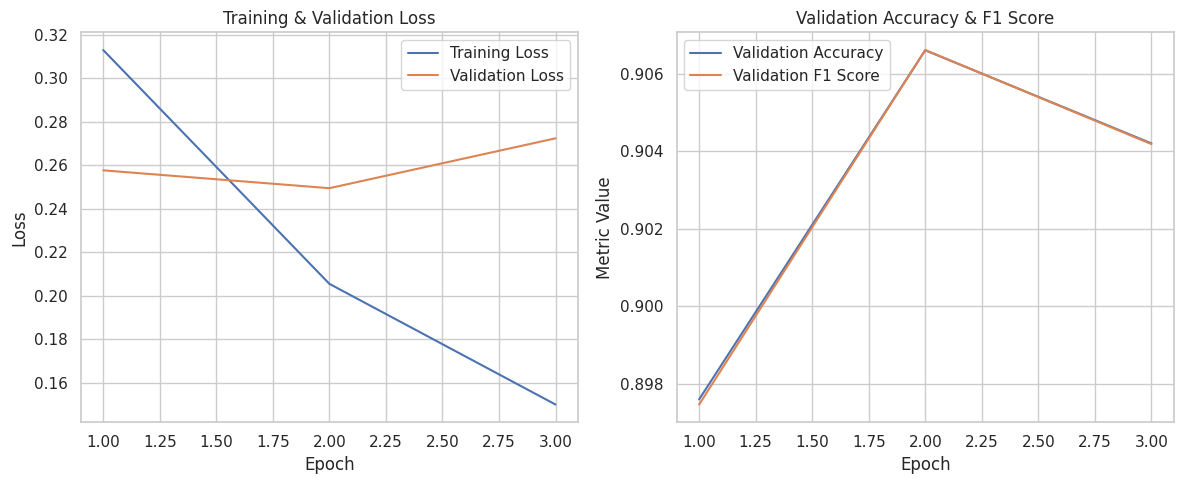

In [333]:
# Plot Training and Validation Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Validation Accuracy and F1 Score
plt.subplot(1, 2, 2)
plt.plot(epochs, validation_accuracy, label='Validation Accuracy')
plt.plot(epochs, validation_f1, label='Validation F1 Score')
plt.title('Validation Accuracy & F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()

plt.tight_layout()
plt.show()


In [244]:
# Predict on Validation Dataset
pred_output = trainer.predict(movies_encoded["validation"])
pred_output

PredictionOutput(predictions=array([[-2.770749  ,  3.1881495 ],
       [-2.7068367 ,  3.14743   ],
       [-0.83728015,  0.9396938 ],
       ...,
       [ 1.1443496 , -1.3421761 ],
       [ 2.3646522 , -2.8565013 ],
       [-2.7474813 ,  3.159141  ]], dtype=float32), label_ids=array([1, 1, 1, ..., 0, 0, 1]), metrics={'test_loss': 0.2723076641559601, 'test_accuracy': 0.9042, 'test_f1': 0.9041819225570327, 'test_runtime': 33.1833, 'test_samples_per_second': 150.678, 'test_steps_per_second': 2.381})

In [245]:
print(f'Output Predition: {pred_output.predictions.shape}')
print(pred_output.predictions)

Output Predition: (5000, 2)
[[-2.770749    3.1881495 ]
 [-2.7068367   3.14743   ]
 [-0.83728015  0.9396938 ]
 ...
 [ 1.1443496  -1.3421761 ]
 [ 2.3646522  -2.8565013 ]
 [-2.7474813   3.159141  ]]


In [246]:
# Decode the predictions greedily using argmax (highest value of all classes)
y_preds = np.argmax(pred_output.predictions, axis=1)
print(f'Output Prediction:{y_preds.shape}')
print(f'Predictions: {y_preds}')

Output Prediction:(5000,)
Predictions: [1 1 1 ... 0 0 1]


In [247]:
# Show metrics of last iteration
pred_output.metrics

{'test_loss': 0.2723076641559601,
 'test_accuracy': 0.9042,
 'test_f1': 0.9041819225570327,
 'test_runtime': 33.1833,
 'test_samples_per_second': 150.678,
 'test_steps_per_second': 2.381}

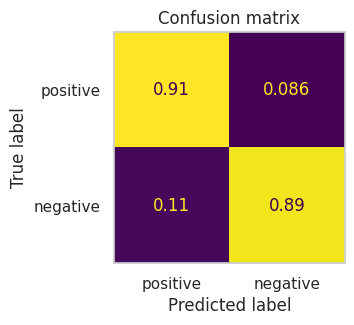

In [248]:
plot_confusion_matrix(y_preds,y_valid,labels)

From the **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">confusion matrix</mark>** we can say that:
- The **fine-tune** approach (using **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">DistilBERT</mark>**)  performs much better than simple extracting **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">embedding</mark>** data and training it on a separate ML model
- **<span style='color:#FFC300'>love</span>** is still often confused with **<span style='color:#FFC300'>joy</span>** (0.08), but much less than the first approach
- **<span style='color:#FFC300'>surprise</span>** is often confused with **<span style='color:#FFC300'>joy</span>** as well (0.09) or fear (0.10), both also much less than the first approach

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-color:#3b3745"><b><span style='color:#F1A424'>6 |</span></b> <b>MODEL ERROR ANALYSIS</b></div>

### <b><span style='color:#F1A424'>Loss Value Mapping</span></b>

We should investigate our models' prediction a little more
- A simple, yet powerful technique is to sort the validateion by the **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">model loss</mark>**
- We can write a function that returns the **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">model loss</mark>**, together with the predicted label `forward_pass_with_label`

In [249]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):

    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

# Convert our dataset back to PyTorch tensors
movies_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
movies_encoded["validation"] = movies_encoded["validation"].map(forward_pass_with_label,
                                                                    batched=True,
                                                                    batch_size=16)

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

### <b><span style='color:#F1A424'>Convert to DataFrame</span></b>

- Create a DataFrame with the text, losses, predicted/true labels

In [251]:
movies_encoded.set_format("pandas")
cols = ["review", "label", "predicted_label", "loss"]
df_test = movies_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str))

- Now we can sort `emotions` encoded by the losses in either assending/descending order
- Let's look at the data samples with the **highest losses** (we can see that high loss values are associated with misspredictions)

In [252]:
show_panel(df_test.sort_values("loss", ascending=False))

Tabulator(page_size=10, pagination='local', show_index=False, value=                          ...)

In [253]:
show_panel(df_test.sort_values("loss", ascending=True))

Tabulator(page_size=10, pagination='local', show_index=False, value=                          ...)

# <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-color:#3b3745"><b><span style='color:#F1A424'>7 |</span></b> <b>USING OUR MODEL</b></div>

- We have trained the model utilising `AutoModelForSequenceClassification` which added a classification head to the base **<mark style="background-color:#FFC300;color:white;border-radius:5px;opacity:0.7">DistilBERT</mark>** model
- We can utilise the `pipeline` method when we need to make model predictions on new unseed data
- Let's say we have new unseen data:
    - 'I watched a movie last night, it was quite brilliant'

In [254]:
# Save the model
trainer.save_model()

### Move the model to drive

In [263]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [267]:
!mkdir -p /content/drive/MyDrive/ML/models/vinai && cp -r /content/vinai /content/drive/MyDrive/ML/models/

In [258]:
from transformers import pipeline

# load from previously saved model
classifier = pipeline("text-classification", model=f"{model_ckpt}-finetuned-emotion")

# New unseen by model data
new_data = 'I watched a movie last night, it was quite brilliant'

- Our model predicts `new_data` to be classified to **label 1** (**joy**)

In [259]:
preds = classifier(new_data, return_all_scores=True)
preds

[[{'label': 'LABEL_0', 'score': 0.9666988849639893},
  {'label': 'LABEL_1', 'score': 0.033301085233688354}]]

In [260]:
preds[0]

[{'label': 'LABEL_0', 'score': 0.9666988849639893},
 {'label': 'LABEL_1', 'score': 0.033301085233688354}]

In [261]:
# Flatten the preds list
flat_preds = [item for sublist in preds for item in sublist]
# Create a DataFrame
df_preds = pd.DataFrame(flat_preds)
df_preds['label'] = df_preds['label'].apply(lambda x: labels[int(x.split('_')[-1])])
px.bar(df_preds, x='label', y=100*df_preds['score'], template='plotly_white')

## Take the test data of the emotions and pass it through the model

In [301]:
emotions = pd.read_csv('data/test.csv')

In [302]:
emotions.tail()

,text,label
1995,i just keep feeling like someone is being unki...,3
1996,im feeling a little cranky negative after this...,3
1997,i feel that i am useful to my people and that ...,1
1998,im feeling more comfortable with derby i feel ...,1
1999,i feel all weird when i have to meet w people ...,4


In [303]:
label_mapping = {
    0: 1,
    1: 0,
    2: 0,
    3: 1,
    4: 1,
    5: 0
}

# Apply mapping to your DataFrame
emotions['label'] = emotions['label'].map(label_mapping)


In [304]:
emotions.tail()

,text,label
1995,i just keep feeling like someone is being unki...,1
1996,im feeling a little cranky negative after this...,1
1997,i feel that i am useful to my people and that ...,0
1998,im feeling more comfortable with derby i feel ...,0
1999,i feel all weird when i have to meet w people ...,1


In [305]:
# Don't forget the class label data
# class_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
class_names = ['negative', 'positive']
ft = Features({'text': Value('string'), 'label': ClassLabel(names=class_names)})

emotions = Dataset.from_pandas(emotions,features=ft)

emotions

Dataset({
    features: ['text', 'label'],
    num_rows: 2000
})

In [306]:
emotions.set_format(type="pandas")
emotions_df = emotions[:]
show_panel(emotions_df)

Tabulator(page_size=10, pagination='local', show_index=False, value=              ...)

In [307]:
# Add label data to dataframe
def label_int2str_em(row):
    return emotions.features["label"].int2str(row)


emotions_df["label_name"] = emotions_df["label"].apply(label_int2str_em)
show_panel(emotions_df)

Tabulator(page_size=10, pagination='local', show_index=False, value=              ...)

In [316]:
preds = classifier(emotions_df['text'].tolist(), return_all_scores=False)


In [315]:
preds[:2]

[{'label': 'LABEL_1', 'score': 0.5497206449508667},
 {'label': 'LABEL_1', 'score': 0.5437413454055786}]

In [323]:

# Map LABEL_X to 'negative' or 'positive'
def map_label(pred_label):
    # Assuming LABEL_1 is 'positive', change according to your mapping
    label_map = {'LABEL_0': 0, 'LABEL_1': 1}
    return label_map[pred_label]

# Add prediction column
emotions_df['predicted_label'] = [map_label(pred['label']) for pred in preds]

In [324]:
emotions_df.head()

,text,label,label_name,predicted_label
0,im feeling rather rotten so im not very ambiti...,1,positive,1
1,im updating my blog because i feel shitty,1,positive,1
2,i never make her separate from me because i do...,1,positive,0
3,i left with my bouquet of red and yellow tulip...,0,negative,0
4,i was feeling a little vain when i did this one,1,positive,1


In [325]:
# Calculate accuracy
accuracy = (emotions_df['predicted_label'] == emotions_df['label']).mean()
print(f"Accuracy: {accuracy}")

Accuracy: 0.541


That means that our classifier trained on binary classification could accuratly classify multi-label emotions upto 54% accuracy

In [326]:
emotions_df.to_csv('sentiment_prediction_for_emotion_datase.csv', index=False)

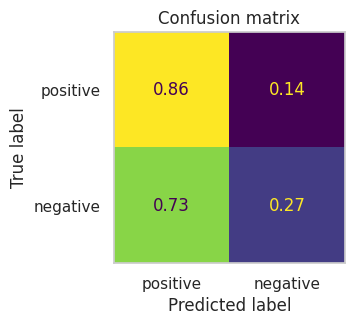

In [328]:
plot_confusion_matrix(emotions_df['predicted_label'],emotions_df['label'],labels)

## Feature Extraction model with emotions Dataset

In [338]:
emotions_df.drop(columns=['predicted_label'], inplace=True)

In [349]:
emotions.reset_format()
emotions['text'][:3]

['im feeling rather rotten so im not very ambitious right now',
 'im updating my blog because i feel shitty',
 'i never make her separate from me because i don t ever want her to feel like i m ashamed with her']

Rename the feature for function compatibility

In [359]:
def rename_feature(column):
    column['review'] = column.pop('text')
    return column

# Apply the function to the dataset
dataset_renamed = emotions.map(rename_feature)

# Update the features to reflect the new structure if necessary
new_features = Features({
    'review': Value('string'),  # Assuming the original type was 'string'
    'label': emotions.features['label']  # Preserve the original label feature
})

emotions = dataset_renamed.cast(new_features)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [360]:
emotions

Dataset({
    features: ['review', 'label'],
    num_rows: 2000
})

In [361]:
# apply to the entire dataset (train,test and validation dataset)
emotions_encoded = emotions.map(tokenise, batched=True, batch_size=None)
print(emotions_encoded.column_names)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

['review', 'label', 'input_ids', 'token_type_ids', 'attention_mask']


In [365]:
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
emotions_encoded

Dataset({
    features: ['review', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 2000
})

In [366]:
# Extract last hidden states (faster w/ GPU)
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)
emotions_hidden.column_names

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

['review',
 'label',
 'input_ids',
 'token_type_ids',
 'attention_mask',
 'hidden_state']

In [367]:
X_valid = np.array(emotions_hidden["hidden_state"])
y_valid = np.array(emotions_hidden["label"])
print(f'Training Dataset: {X_valid.shape}')
print(f'Validation Dataset {y_valid.shape}')

Training Dataset: (2000, 768)
Validation Dataset (2000,)


**The actual accuracy offered by feature extractor method for sentiment model on emotion dataset**

In [369]:
# lr_clf = LR(max_iter = 2000)
# lr_clf.fit(X_train, y_train)
y_preds = lr_clf.predict(X_valid)
print(f'accuracy: {lr_clf.score(X_valid, y_valid)}')

accuracy: 0.631


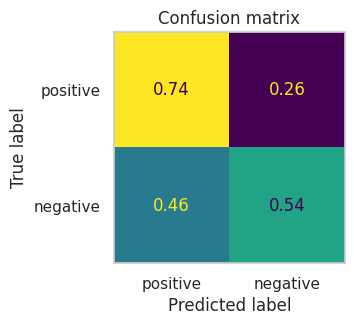

In [371]:
plot_confusion_matrix(y_preds,y_valid,labels)